# Movie making with napari

Guillaume Witz, Science IT Support, Microscopy Imaging Center, Bern University

## Load packages

In [11]:
import numpy as np
from naparimovie.naparimovie import Movie
import napari
import skimage.morphology
%gui qt5

## Create an artificial dataset

To illustrate the different options, an artificial dataset is create here. Two time-lapse 3D stacks are created, one being just background, and the other a set of randomly positioned particles that move and eventually form a pattern.

In [12]:
cube_size = 50
time = 40
num_points = 20

#generate objects coordinates
coords = np.random.randint(3,cube_size-3,(num_points,3))
all_coords=[]
all_coords.append(np.concatenate((0*np.ones((num_points,1)),coords),axis = 1))
refs = np.stack((np.linspace(1,cube_size-1, num_points).astype(int),
                 cube_size/2+np.array([(cube_size/3)*np.cos(x*2*np.pi/num_points) for x in range(num_points)]),
                cube_size/2+np.array([(cube_size/3)*np.sin(x*2*np.pi/num_points) for x in range(num_points)])),axis = 1)


#randomly move points and pull them towards a helix shape
for t in range(1,time):
    coords = coords + 0.1*np.random.randn(num_points,3)-0.08*(coords-refs)#0.1*np.sqrt(np.sum((coords-refs)**2,axis = 1))
    all_coords.append(np.concatenate((t*np.ones((num_points,1)),coords),axis = 1))

coords_time = np.concatenate(all_coords).astype(int)

#generate images
image = np.random.randn(1, cube_size,cube_size,cube_size)
image = (np.ones((time,1,1,1))*image)
image2 = np.zeros((time, cube_size,cube_size,cube_size))
image2[coords_time[:,0],coords_time[:,1],coords_time[:,2],coords_time[:,3]] = 1
image2 = skimage.filters.gaussian(image2, (0,1,1,1))

## Setting key-frames

Here the two images are visualized through napari. The napari view object is then used to create a ```Movie``` instance. At this point, when the napari window is in foreground, one can use a set of commands to create and modify key-frames. Those key-frames are then interpolated to create a smooth movie. For each key-frame the following properties can be changed:

- object rotation
- object displacement
- time frame
- field of view
- visibility of different layers

The following keys can be used to handle key-frames:
- f : set current view as key-frame. The key-frame is added right after the current key-frame. If you move between key-frames using a,b (see below) this allows you to insert key-frames at specific positions
- r : replace current key-frame with adjusted view
- d : delete current key-frame
- a : go to next key-frame
- b : go to previous key-frame
- w : go through interpolated key-frames

In [13]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image, scale=(1,1,1))
viewer.add_image(image2, scale=(1,1,1), blending = 'additive', colormap = 'yellow')
movie = Movie(myviewer=viewer)

## Save movie

Adjust the number of interpolated frames between key-frames. To check if it's ok, you can use the ```w``` key to progress through the movie.

In [9]:
movie.inter_steps = 15

Finally save the movie. You can pick a name (or path), the resolution in dpi and the number of frames per second.

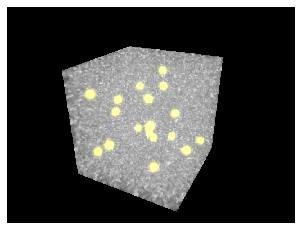

In [10]:
movie.make_movie(name = 'movie.mp4', resolution = 300, fps = 20)

## Save stack

It's also possible to extract the stack of snapshots to save it into another format. For example here we save the stack as a .tif file which can e.g. be re-opened into Fiji:

In [17]:
stack = movie.collect_images()
skimage.io.imsave('movie.tif', stack, plugin='tifffile')